In [5]:
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
columns = [f"f{i}" for i in range(34)] + ["label"]
df = pd.read_csv(url, header=None, names=columns)

X = df.iloc[:, :-1].values
y_raw = df["label"].values
y = (y_raw == 'b').astype(int)  # 'b' = anomalie, 'g' = normalne

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_samples = trial.suggest_float("max_samples", 0.2, 1.0)
    contamination = trial.suggest_float("contamination", 0.01, 0.2)
    max_features = trial.suggest_float("max_features", 0.3, 1.0)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    model = IsolationForest(
        n_estimators=n_estimators,
        max_samples=max_samples,
        contamination=contamination,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train)
    y_pred = model.predict(X_val)
    y_pred = (y_pred == -1).astype(int)

    return f1_score(y_val, y_pred)


study = optuna.create_study(
    direction="maximize",
    study_name="iforest_ionosphere",
    storage="sqlite:///iforest_ionosphere.db",
    load_if_exists=True
)
study.optimize(objective, n_trials=200)

print("Best score:", study.best_value)
print("Best params:", study.best_params)


[I 2025-05-15 11:08:11,132] Using an existing study with name 'iforest_ionosphere' instead of creating a new one.
[I 2025-05-15 11:08:13,395] Trial 1 finished with value: 0.48484848484848486 and parameters: {'n_estimators': 359, 'max_samples': 0.8761444872042756, 'contamination': 0.10021917062994845, 'max_features': 0.7917555369555768, 'bootstrap': True}. Best is trial 1 with value: 0.48484848484848486.
[I 2025-05-15 11:08:15,212] Trial 2 finished with value: 0.3870967741935484 and parameters: {'n_estimators': 285, 'max_samples': 0.6539170748079364, 'contamination': 0.05272092482499003, 'max_features': 0.7818070289189806, 'bootstrap': False}. Best is trial 1 with value: 0.48484848484848486.
[I 2025-05-15 11:08:16,487] Trial 3 finished with value: 0.48484848484848486 and parameters: {'n_estimators': 206, 'max_samples': 0.4467544040669658, 'contamination': 0.12547534514384437, 'max_features': 0.4943565704989282, 'bootstrap': False}. Best is trial 1 with value: 0.48484848484848486.
[I 202

Best score: 0.6486486486486487
Best params: {'n_estimators': 128, 'max_samples': 0.8834294960078559, 'contamination': 0.19197787485947843, 'max_features': 0.30113608097697614, 'bootstrap': False}


In [21]:
import optuna
from sklearn.tree import DecisionTreeRegressor


study = optuna.load_study(study_name="iforest_ionosphere", storage="sqlite:///iforest_ionosphere.db")


df = study.trials_dataframe()


df = df[df["state"] == "COMPLETE"]


df_model = df.drop(columns=["number", "state", "datetime_start", "datetime_complete", "duration"])
df_model = df_model.dropna(axis=1, how='all')
df_model = df_model.dropna()
print(df_model)

X = df_model.drop(columns=["value"])
y = df_model["value"]
tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(X, y)


        value  params_bootstrap  params_contamination  params_max_features  \
1    0.484848              True              0.100219             0.791756   
2    0.387097             False              0.052721             0.781807   
3    0.484848             False              0.125475             0.494357   
4    0.529412              True              0.159739             0.427429   
5    0.275862              True              0.043745             0.561610   
..        ...               ...                   ...                  ...   
196  0.529412             False              0.194817             0.329089   
197  0.529412             False              0.187890             0.355103   
198  0.484848              True              0.072182             0.380311   
199  0.571429              True              0.179253             0.341583   
200  0.571429              True              0.196532             0.396111   

     params_max_samples  params_n_estimators  
1              0

DecisionTreeRegressor(max_depth=4, random_state=42)

In [22]:
importances = tree.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.4f}")


params_bootstrap: 0.0000
params_contamination: 0.9158
params_max_features: 0.0183
params_max_samples: 0.0204
params_n_estimators: 0.0456


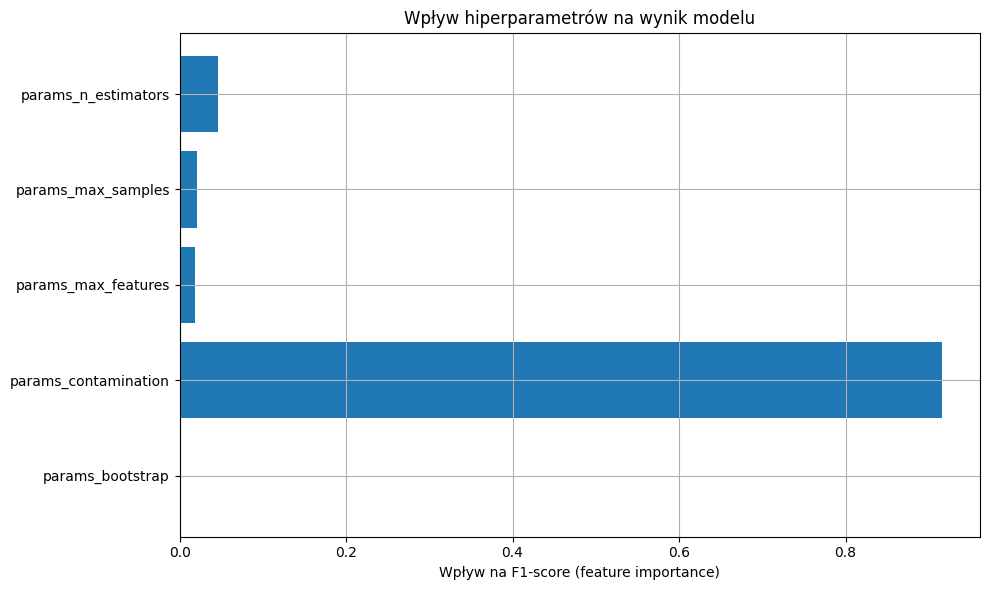

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances)
plt.xlabel("Wpływ na F1-score (feature importance)")
plt.title("Wpływ hiperparametrów na wynik modelu")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
columns = [f"f{i}" for i in range(34)] + ["label"]
df = pd.read_csv(url, header=None, names=columns)

X = df.iloc[:, :-1].values
y_raw = df["label"].values
y = (y_raw == 'b').astype(int)  # 1 = anomalia (bad), 0 = normalna (good)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)



def objective(trial):
    model_name = trial.suggest_categorical("model", ["IsolationForest", "OneClassSVM", "EllipticEnvelope", "LOF"])

    n_estimators = trial.suggest_int("n_estimators", 1, 500)
    max_samples = trial.suggest_float("max_samples", 0.1, 1.0)
    contamination = trial.suggest_float("contamination", 0.01, 0.5)
    max_features = trial.suggest_float("max_features", 0.1, 1.0)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    kernel = trial.suggest_categorical("kernel", ["rbf", "sigmoid", "poly"])
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    nu = trial.suggest_float("nu", 0.01, 0.5)

    support_fraction = trial.suggest_float("support_fraction", 0.1, 1.0)

    n_neighbors = trial.suggest_int("n_neighbors", 10, 100)


    if model_name == "IsolationForest":
        model = IsolationForest(
            n_estimators=n_estimators,
            max_samples=max_samples,
            contamination=contamination,
            max_features=max_features,
            bootstrap=bootstrap,
            random_state=42, n_jobs=-1
        )
    elif model_name == "OneClassSVM":
        model = OneClassSVM(
            kernel=kernel,
            gamma=gamma,
            nu=nu
        )
    elif model_name == "EllipticEnvelope":
        model = EllipticEnvelope(
            contamination=contamination,
            support_fraction=support_fraction,
            random_state=42
        )
    elif model_name == "LOF":
        model = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            contamination=contamination,
            novelty=True,
            n_jobs=-1
        )
    else:
        raise ValueError("Nieznany model")

    model.fit(X_train)
    y_pred = model.predict(X_val)
    y_pred = (y_pred == -1).astype(int)

    return f1_score(y_val, y_pred)


study = optuna.create_study(
    direction="maximize",
    study_name="multi_model_outlier_study_3",
    storage="sqlite:///multi_model_outliers_3.db",
    load_if_exists=True
)
study.optimize(objective, n_trials=1000)


RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xe. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

[I 2025-05-15 22:24:42,353] A new study created in RDB with name: multi_model_outlier_study_3
/home/pawel/anaconda3/envs/AI/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
[I 2025-05-15 22:24:43,612] Trial 0 finished with value: 0.48484848484848486 and parameters: {'model': 'EllipticEnvelope', 'n_estimators': 229, 'max_samples': 0.9175353648743605, 'contamination': 0.11479435505694757, 'max_features': 0.8325907910447286, 'bootstrap': True, 'kernel': 'sigmoid', 'gamma': 'scale', 'nu': 0.09980492035743642, 'support_fraction': 0.9360475924511346, 'n_neighbors': 96}. Best is trial 0 with value: 0.48484848484848486.
/home/pawel/anaconda3/envs/AI/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
[I 2025-05-15 22:24:44,858] Trial 1 finished with value: 

In [3]:
import optuna
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

study = optuna.load_study(study_name="multi_model_outlier_study_3", storage="sqlite:///multi_model_outliers_3.db")
df = study.trials_dataframe()

df = df[df["state"] == "COMPLETE"]

df_model = df[[col for col in df.columns if col.startswith("params_")] + ["value"]]

categorical_cols = [col for col in df_model.columns if df_model[col].dtype == "object"]
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)


X = df_model.drop(columns=["value"])
y = df_model["value"]


tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(X, y)



DecisionTreeRegressor(max_depth=4, random_state=42)

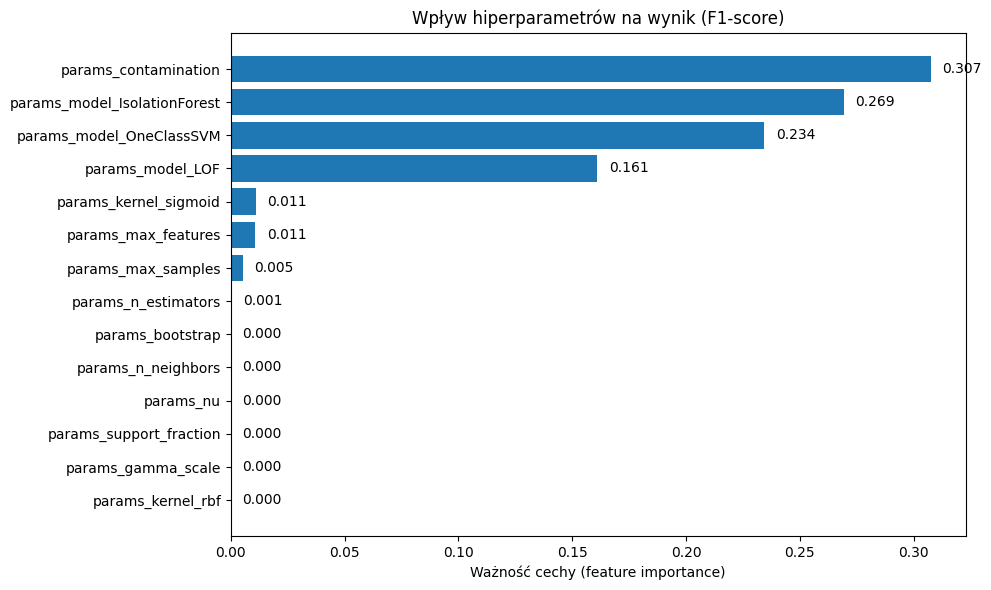

In [2]:
importances = tree.feature_importances_

importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df["feature"], importance_df["importance"])


for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2,
             f"{width:.3f}", va='center')

plt.xlabel("Ważność cechy (feature importance)")
plt.title("Wpływ hiperparametrów na wynik (F1-score)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

